# Notebook de Modelado - Proyecto de Pronósticos

En este notebook implementaremos los modelos de machine learning para generar pronósticos basados en los datos procesados.

## 1. Importación de librerías

In [1]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*FigureCanvasAgg is non-interactive.*"
)
import os
os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
np.set_printoptions(suppress=True)
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
from utilsforecast.plotting import plot_series as plot_series_utils
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 5)
    ,"figure.dpi": 100
    ,"savefig.dpi": 300
    ,"figure.constrained_layout.use": True
    ,"axes.titlesize": 12
    ,"axes.labelsize": 10
    ,"xtick.labelsize": 9
    ,"ytick.labelsize": 9
    ,"legend.fontsize": 9
    ,"legend.title_fontsize": 10
})
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
from fpppy.utils import plot_series

# Configuraciones
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


from functools import partial
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsforecast.models import AutoTBATS
from statsforecast.models import AutoARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, Markdown, Image

# Importar función de carga desde el módulo etl
from src.etl import load_dict_from_csv

from src.modelling_tools import compile_models_output, evaluate_models_metrics

from src.modelling_tools import build_X_future_step, plot_ets_decomposition, plot_residual_analysis, perform_residual_tests, forecast_with_corrected_dates, create_hybrid_forecast, plot_forecast_with_intervals, calculate_annual_variation, plot_annual_comparison, export_data

2025-10-15 02:24:44.838 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-15 02:24:44.841 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-15 02:24:44.841 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


## 2. Carga de datos

In [2]:
# # Cargar todos los datasets usando la función existente
datasets = load_dict_from_csv("data/csv", parse_dates=True)

In [3]:
reno = datasets["Ingresos RUNEOL"]
reno = reno[reno['Fecha'] > '2022-12-31']

# # Comentar/descomentar si se quiere probar transformación logarítmica
# reno["Ingresos RUNEOL"] = np.log(reno["Ingresos RUNEOL"])

In [4]:
reno.rename(columns={"Fecha": "ds", "Ingresos RUNEOL": "y"}, inplace=True)
reno["unique_id"] = 1

In [5]:
reno_x = reno.copy()
reno_x["Cambio_tarifa"] = np.where(reno_x["ds"] >= "2025-01-01", 1, 0)

# # Comentar/descomentar si se quiere probar transformación logarítmica
# reno_x["y"] = np.log(reno_x["y"])

# 3. Modelación

In [6]:
import pandas as pd

from statsforecast import StatsForecast
from statsforecast.models import AutoETS

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape

## Sin exógenas

### Model config

In [7]:
import inspect
from utilsforecast.evaluation import evaluate
print(inspect.signature(evaluate))
# ---------------------------
# Config
# ---------------------------
H = 15                 # forecast horizon = 15 months
SEASON_LEN = 12        # for ETS seasonality
# ---------------------------
# ETS models (ANM/AAM excluded)
# ---------------------------
models = [
    # ===== ETS que ya tienes =====
    # No seasonality
    AutoETS(season_length=SEASON_LEN, model="ANN", alias="ANN"),
    AutoETS(season_length=SEASON_LEN, model="AAN", alias="AAN"),
    AutoETS(season_length=SEASON_LEN, model="AAN", damped=True, alias="AANd"),
    AutoETS(season_length=SEASON_LEN, model="MNN", alias="MNN"),
    AutoETS(season_length=SEASON_LEN, model="MAN", alias="MAN"),
    AutoETS(season_length=SEASON_LEN, model="MAN", damped=True, alias="MANd"),
    # Additive seasonality
    AutoETS(season_length=SEASON_LEN, model="ANA", alias="ANA"),
    AutoETS(season_length=SEASON_LEN, model="AAA", alias="AAA"),
    AutoETS(season_length=SEASON_LEN, model="AAA", damped=True, alias="AAAd"),
    AutoETS(season_length=SEASON_LEN, model="MAA", alias="MAA"),
    AutoETS(season_length=SEASON_LEN, model="MAA", damped=True, alias="MAAd"),
    # Multiplicative seasonality (requires y > 0)
    AutoETS(season_length=SEASON_LEN, model="MAM", alias="MAM"),
    AutoETS(season_length=SEASON_LEN, model="MAM", damped=True, alias="MAMd"),
    AutoETS(season_length=SEASON_LEN, model="MMM", alias="MMM"),
    AutoETS(season_length=SEASON_LEN, model="MMM", damped=True, alias="MMMd"),


    # ARIMA FAMILY
    AutoARIMA(stepwise=False, approximation=False, alias="auto", season_length=12),


#     # ===== TBATS family ===== Después de ejecutarlo, TBATS no mejora nada en este caso y tarda en ejecutarse =====
#     # Selección automática (prueba con/sin Box-Cox, tendencia, amortiguación y ARMA via AIC)
#     AutoTBATS(season_length=[SEASON_LEN], alias="AutoTBATS"),
#     # Variante fija: forzar Box-Cox y ARMA si quieres comparar contra la auto
#     AutoTBATS(season_length=[SEASON_LEN], use_boxcox=True, use_arma_errors=True, alias="TBATS_BC_ARMA"),
]

(df: ~AnyDFType, metrics: List[Callable], models: Optional[List[str]] = None, train_df: Optional[~AnyDFType] = None, level: Optional[List[int]] = None, id_col: str = 'unique_id', time_col: str = 'ds', target_col: str = 'y', agg_fn: Optional[str] = None) -> ~AnyDFType


### Model Fitting

In [8]:
sf = StatsForecast(models=models, freq="M")
# Usar la función wrapper para corregir las fechas de pronóstico
fc = forecast_with_corrected_dates(sf, df=reno, h=H, level=[90, 95], fitted=True, freq='M')
fitted_values = sf.forecast_fitted_values()
models_dict = compile_models_output(fitted_values)

In [9]:
pronostico_ets = fc.copy()

### Model Evaluation

In [10]:
# Evaluar modelos con métricas (RMSE, MAE, MAPE)
metrics_results_01 = evaluate_models_metrics(models_dict)
pd.set_option('display.float_format', '{:.2f}'.format)
metrics_results_01

,model,rmse,mae,mape
0,AAAd,222703.84,168670.03,625.82
1,AAA,242166.61,175510.77,653.55
2,ANA,252433.41,186474.93,501.75
3,MAMd,326839.57,174087.30,84.78
4,MAM,340002.48,182964.56,87.56
5,auto,353128.00,152488.73,59.57
6,MAA,375548.84,252350.54,583.44
7,MAAd,413147.84,234728.24,458.28
8,MMMd,789773.31,374720.69,82.37
9,AAN,1562155.34,965183.57,675.28


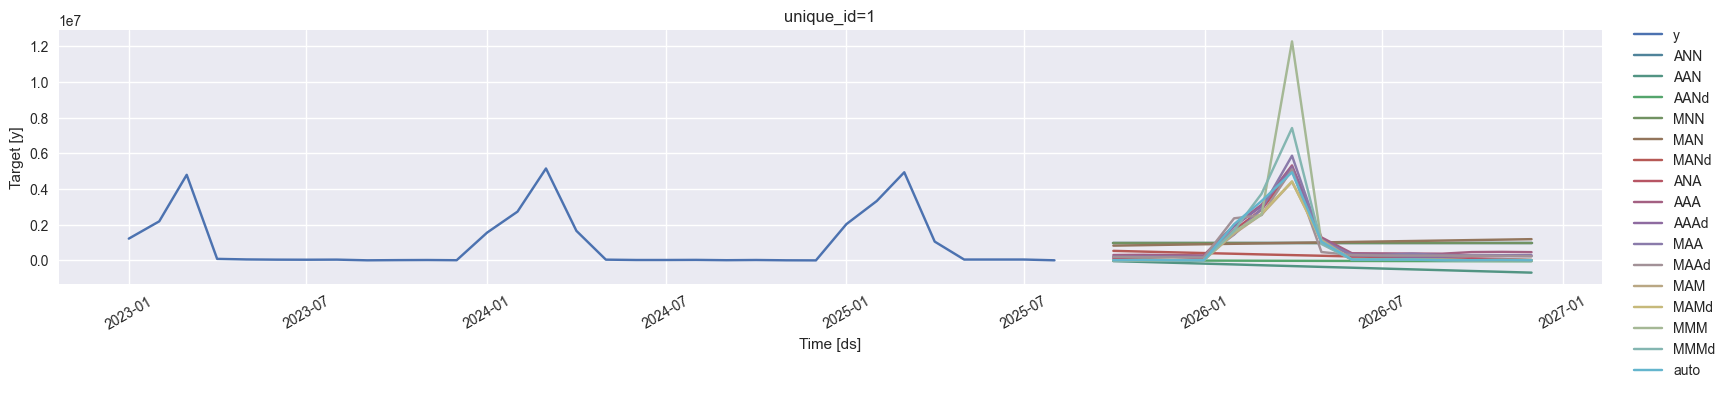

In [11]:
sf = sf.fit(reno)
plot_series(reno, fc)

In [12]:
fitted_best_model_01 = sf.fitted_[0,13].model_

**Observaciones**

- El mejor modelo es el ETS(MMM)
- El modelo TBATS no mejora el desempeño del ETS(MMM)

## Con exógenas

### Model config

In [13]:
import inspect
from utilsforecast.evaluation import evaluate
print(inspect.signature(evaluate))
# ---------------------------
# Config
# ---------------------------

H = 15
models = [
    # ARIMA FAMILY
    AutoARIMA(stepwise=False, approximation=False, alias="auto", season_length=12),

]

(df: ~AnyDFType, metrics: List[Callable], models: Optional[List[str]] = None, train_df: Optional[~AnyDFType] = None, level: Optional[List[int]] = None, id_col: str = 'unique_id', time_col: str = 'ds', target_col: str = 'y', agg_fn: Optional[str] = None) -> ~AnyDFType


### Model Fitting

In [14]:
sf = StatsForecast(models=models, freq="M")

sf = sf.fit(
    df=reno_x,
    target_col="y",
)

# Crear X_future con valores específicos para la variable exógena
X_future = build_X_future_step(reno_x, H, freq='M', exog_values={'Cambio_tarifa': 1})

# Generar pronósticos con variables exógenas usando la función wrapper
fc = forecast_with_corrected_dates(sf, df=reno_x, h=H, level=[90, 95], fitted=True, X_df=X_future, freq='M')

pronostico_auto_arima_x = fc.copy()

# # Obtener valores ajustados para análisis posterior
fitted_values = sf.forecast_fitted_values()
models_dict = compile_models_output(fitted_values)

In [15]:
fc

,unique_id,ds,auto,auto-lo-95,auto-lo-90,auto-hi-90,auto-hi-95
0,1,2025-09-30,2765.80,-934529.28,-783837.03,789368.64,940060.89
1,1,2025-10-31,14365.80,-986477.17,-825568.10,854299.70,1015208.78
2,1,2025-11-30,-3034.20,-1063624.24,-893109.42,887041.03,1057555.85
3,1,2025-12-31,-7234.20,-1124380.48,-944772.91,930304.52,1109912.09
4,1,2026-01-31,1538239.32,367265.20,555526.86,2520951.79,2709213.45
5,1,2026-02-28,2835839.32,1613405.28,1809940.34,3861738.31,4058273.36
6,1,2026-03-31,4443839.32,3172025.83,3376499.79,5511178.85,5715652.82
7,1,2026-04-30,562239.32,-757106.78,-544990.83,1669469.48,1881585.43
8,1,2026-05-31,-442560.68,-1807785.47,-1588293.44,703172.08,922664.11
9,1,2026-06-30,-442560.68,-1852171.72,-1625543.56,740422.21,967050.37


### Model Evaluation

In [16]:
# Evaluar modelos con métricas (RMSE, MAE, MAPE)
metrics_results = evaluate_models_metrics(models_dict)
pd.set_option('display.float_format', '{:.2f}'.format)
metrics_results

,model,rmse,mae,mape
0,auto,348560.14,175224.76,378.64


### Decomposition

In [17]:
fitted_best_model_02 = sf.fitted_[0,0].model_

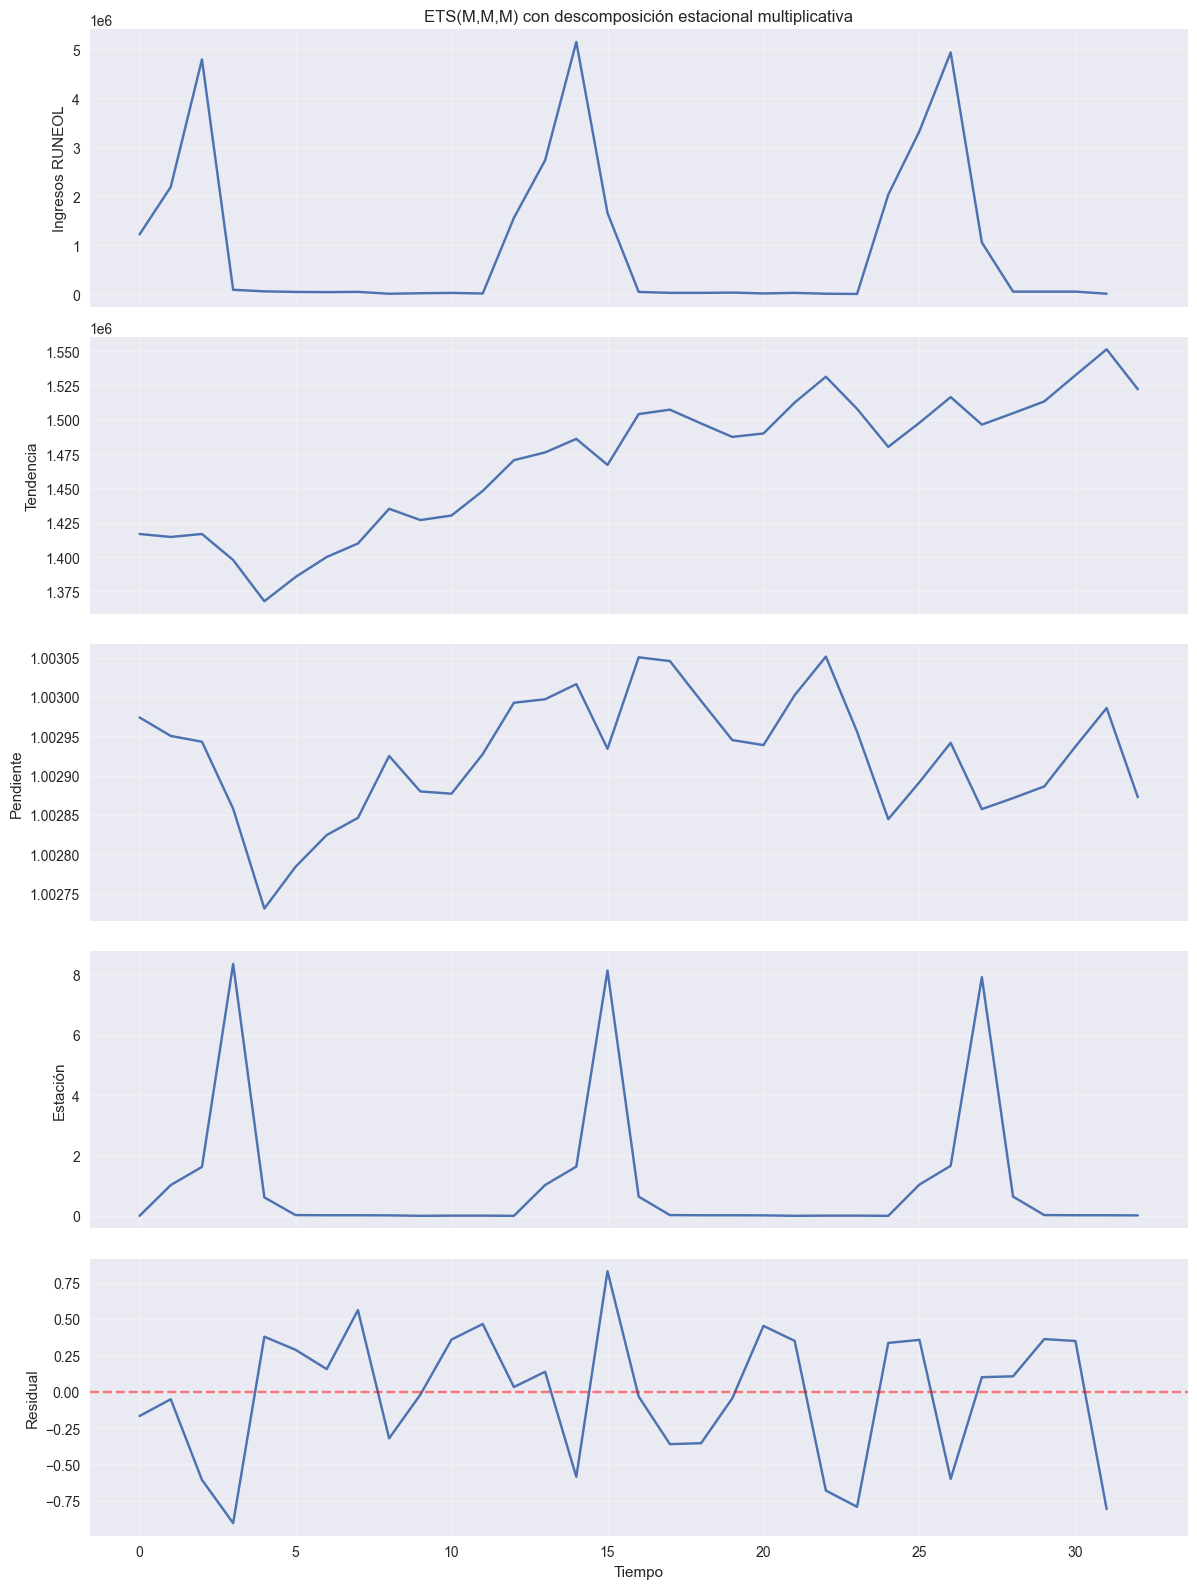

In [18]:
# Crear gráfico de descomposición usando la función
fig, axes = plot_ets_decomposition(
    original_data=reno_x["y"].values,
    fitted_model=fitted_best_model_01,
    title="ETS(M,M,M) con descomposición estacional multiplicativa",
    y_label="Ingresos RUNEOL"
)
plt.show()

### Residuals check

##### Decomposition model

In [19]:
# Importar librerías necesarias para análisis de residuales
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox  # Importación correcta para ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np

# Extraer residuales
residuales_2 = fitted_best_model_02["residuals"]
fitted_val_2 = models_dict["auto"]["fitted"].values
# Calcular valores ajustados correctamente
original_values_2 = reno["y"].values


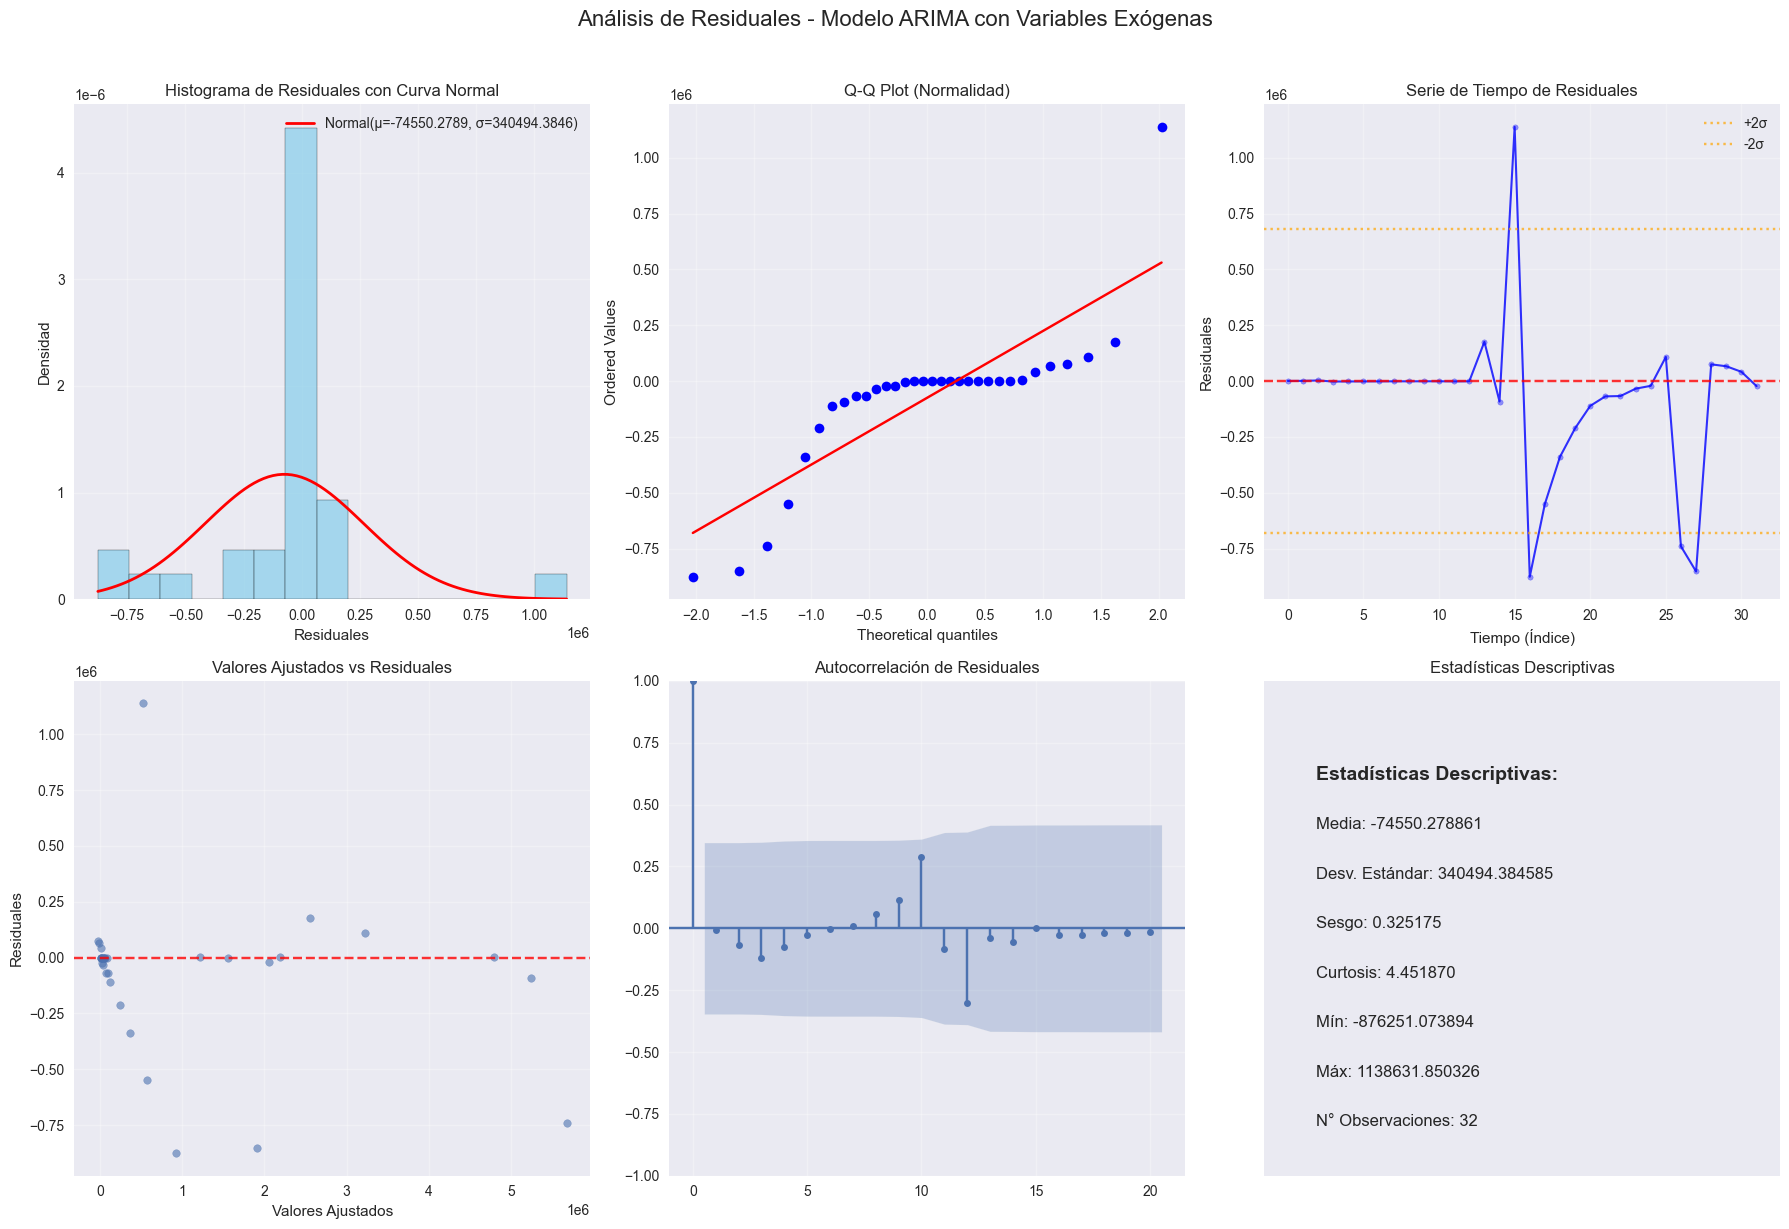

In [20]:
# Crear análisis gráfico de residuales para el modelo ARIMA con variables exógenas
fig, axes = plot_residual_analysis(
    residuals=residuales_2,
    fitted_values=fitted_val_2,
    title="Análisis de Residuales - Modelo ARIMA con Variables Exógenas",
    bins=15,
    lags=20
)
plt.show()

In [21]:
# Importar librerías necesarias para análisis de residuales
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox  # Importación correcta para ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np

# Extraer residuales
residuales = fitted_best_model_01["residuals"]
fitted_val = models_dict["auto"]["fitted"].values
# Calcular valores ajustados correctamente
original_values = reno["y"].values


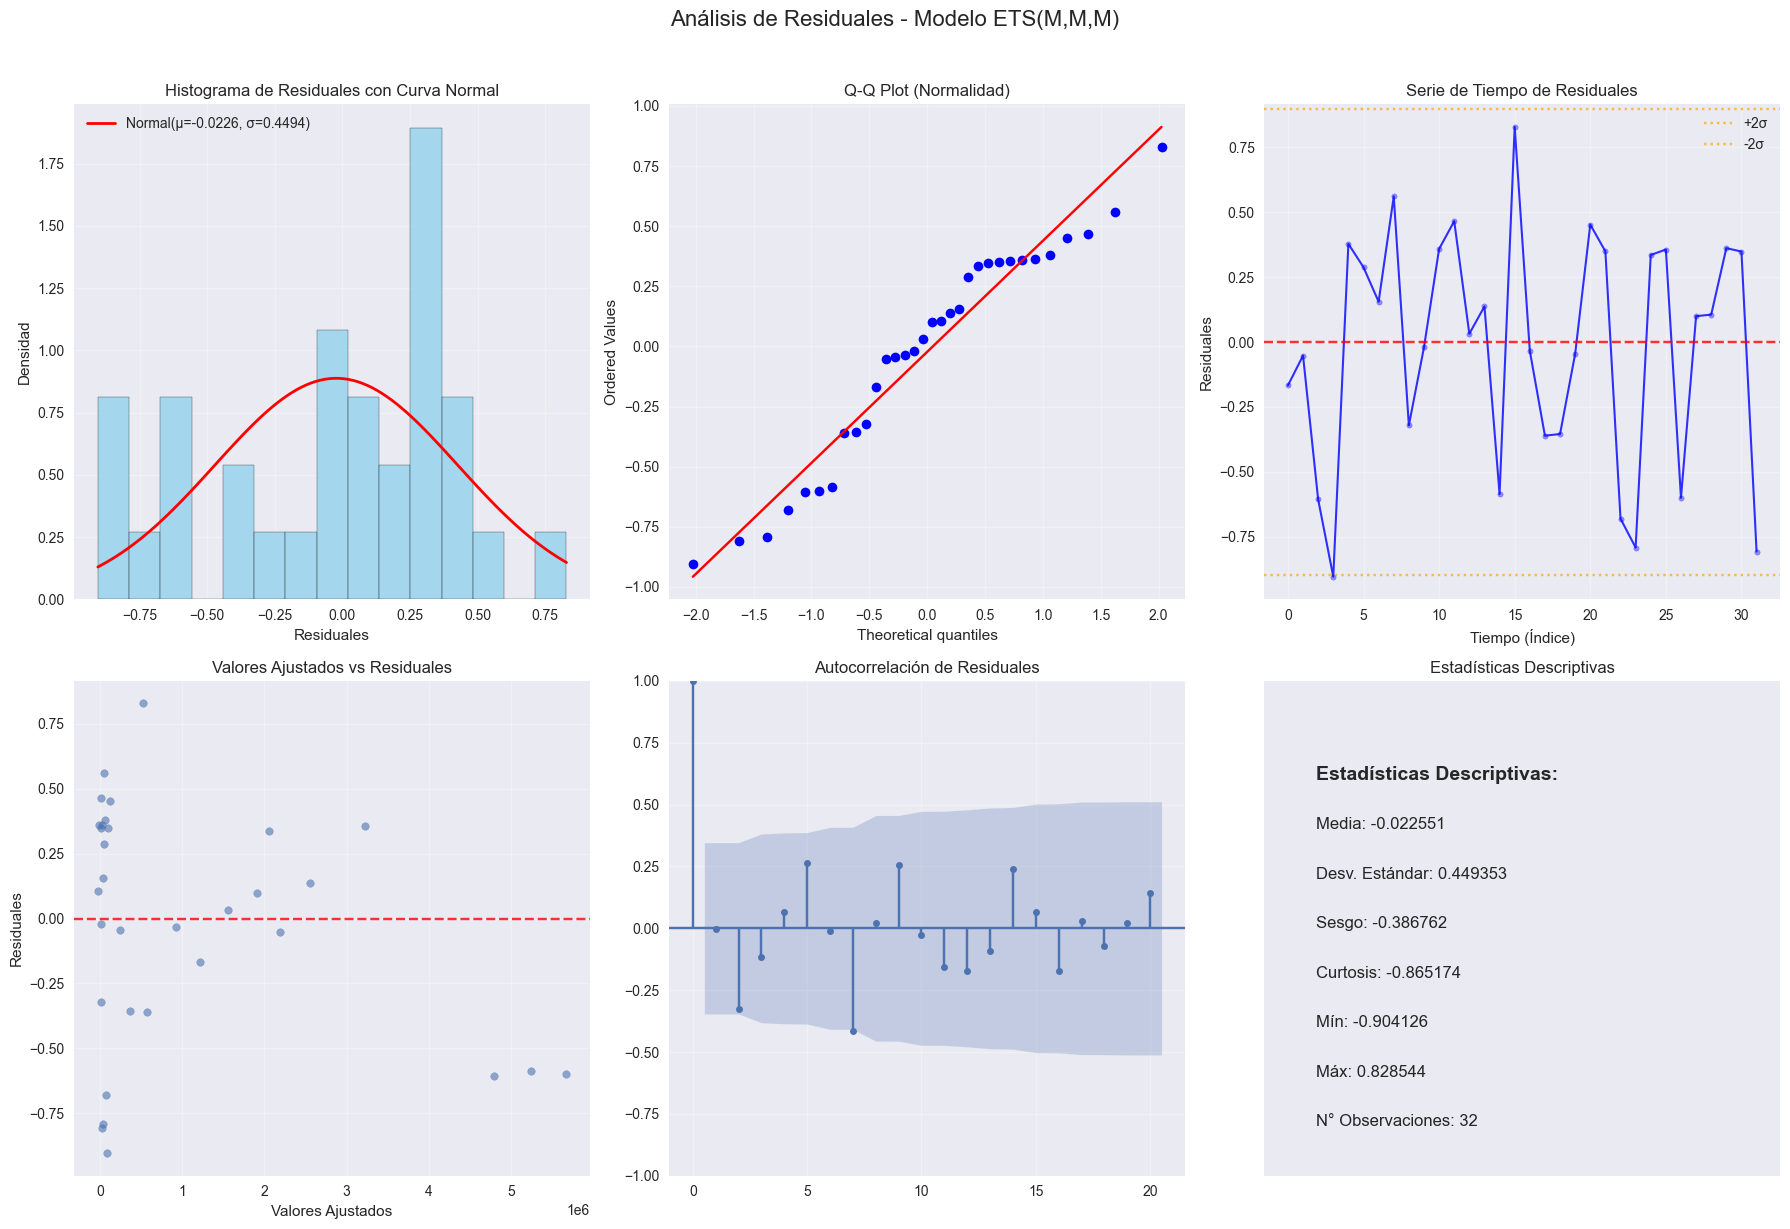

In [22]:
# Crear análisis gráfico de residuales usando la función
fig, axes = plot_residual_analysis(
    residuals=residuales,
    fitted_values=fitted_val,
    title="Análisis de Residuales - Modelo ETS(M,M,M)",
    bins=15,
    lags=20
)
plt.show()

In [23]:
# Realizar todas las pruebas estadísticas de residuales usando la función
results_residuales = perform_residual_tests(
    residuals=residuales,
    title="Análisis Estadístico de Residuales - Modelo ETS(M,M,M)",
    alpha=0.05
)

ANÁLISIS ESTADÍSTICO DE RESIDUALES - MODELO ETS(M,M,M)

1. PRUEBAS DE NORMALIDAD:
------------------------------
Shapiro-Wilk Test:
   Estadístico: 0.942814
   p-valor: 0.089998
   Conclusión: No se rechaza normalidad

Jarque-Bera Test:
   Estadístico: 1.795820
   p-valor: 0.407420
   Sesgo: -0.386762
   Curtosis: 2.134826
   Conclusión: No se rechaza normalidad

Anderson-Darling Test:
   Estadístico: 0.751570
   Valor crítico (5%): 0.715000
   Conclusión: Residuales NO siguen distribución normal


2. PRUEBAS DE AUTOCORRELACIÓN:
------------------------------
Ljung-Box Test (lag 10):
   Estadístico: 17.986475
   p-valor: 0.055192
   Conclusión: No hay autocorrelación significativa

Durbin-Watson Test:
   Estadístico: 1.905090
   Interpretación: Sin autocorrelación fuerte


3. PRUEBAS DE HOMOCEDASTICIDAD:
------------------------------
Breusch-Pagan Test:
   Estadístico LM: 0.199157
   p-valor: 0.655403
   Estadístico F: 0.187879
   p-valor F: 0.667789
   Conclusión: No hay heterocedast

In [24]:
# Ejemplo de uso con los residuales del modelo ARIMA (comentado porque no están definidos aún)
results_arima = perform_residual_tests(
    residuals=residuales_2,
    title="Análisis Estadístico de Residuales - Modelo ARIMA con Variables Exógenas",
    alpha=0.05
)

ANÁLISIS ESTADÍSTICO DE RESIDUALES - MODELO ARIMA CON VARIABLES EXÓGENAS

1. PRUEBAS DE NORMALIDAD:
------------------------------
Shapiro-Wilk Test:
   Estadístico: 0.724579
   p-valor: 0.000002
   Conclusión: Residuales NO siguen distribución normal

Jarque-Bera Test:
   Estadístico: 26.989465
   p-valor: 0.000001
   Sesgo: 0.325175
   Curtosis: 7.451870
   Conclusión: Residuales NO siguen distribución normal

Anderson-Darling Test:
   Estadístico: 3.908675
   Valor crítico (5%): 0.715000
   Conclusión: Residuales NO siguen distribución normal


2. PRUEBAS DE AUTOCORRELACIÓN:
------------------------------
Ljung-Box Test (lag 10):
   Estadístico: 5.835192
   p-valor: 0.828914
   Conclusión: No hay autocorrelación significativa

Durbin-Watson Test:
   Estadístico: 1.921599
   Interpretación: Sin autocorrelación fuerte


3. PRUEBAS DE HOMOCEDASTICIDAD:
------------------------------
Breusch-Pagan Test:
   Estadístico LM: 0.971969
   p-valor: 0.324190
   Estadístico F: 0.939766
   p-val

# Forecast

**Observaciones**

- Para este caso, modelamos meses de dos formas diferentes. Todos los meses a excepción de Marzo serán modelados usando ETS incluyendo datos de un año después de la pandemia. Este modelo presenta el mejor comportamiento para captar la estacionalidad y tendencia de la serie, sin embargo, es débil en captar la variabilidad que hay a lo largo de los años durante el mes de marzo. Esto ocurre porque fenómenos exógenos (como intervenciones de política, cambios en la tarifa, o evento extraordinarios), pueden tener un efecto considerable y no son estables, por lo tanto, se requieren incluir otras variables para captarlos. Desafortunadamente, este modelo no permite agregar variables exogénas, por lo tanto se plantea un modelo híbrido para proyectar específicamente el mes de marzo con un modelo que si lo permita.

- El segundo modelo, no tiene es el mejor para captar los patrones tendenciales y estacionales sobre los demás meses, pero permite incluir el efecto de la intervención. En este caso, asumimos que el efecto está captado por la introducción del cambio tarifario a partir de 2025. A partir de este modelo predecimos el mes de marzo.



In [25]:
pronostico_ets = pronostico_ets[["ds", "MMM", "MMM-lo-90", "MMM-hi-90", "MMM-lo-95", "MMM-hi-95"]]
pronostico_ets

,ds,MMM,MMM-lo-90,MMM-hi-90,MMM-lo-95,MMM-hi-95
0,2025-09-30,8325.64,-962.83,17614.11,-2742.26,19393.53
1,2025-10-31,17627.24,8338.76,26915.71,6559.34,28695.13
2,2025-11-30,17572.88,8284.40,26861.35,6504.98,28640.77
3,2025-12-31,7550.64,-1737.84,16839.11,-3517.26,18618.53
4,2026-01-31,1605192.87,1595904.40,1614481.34,1594124.97,1616260.77
5,2026-02-28,2569790.71,2560502.24,2579079.18,2558722.81,2580858.60
6,2026-03-31,12264375.03,12255036.20,12273713.87,12253247.12,12275502.94
7,2026-04-30,998999.97,989614.14,1008385.81,987816.06,1010183.89
8,2026-05-31,45907.95,-110046.34,201862.25,-139923.05,231738.95
9,2026-06-30,37597.06,-481416.39,556610.51,-580845.61,656039.73


In [26]:
pronostico_auto_arima_x

,unique_id,ds,auto,auto-lo-95,auto-lo-90,auto-hi-90,auto-hi-95
0,1,2025-09-30,2765.80,-934529.28,-783837.03,789368.64,940060.89
1,1,2025-10-31,14365.80,-986477.17,-825568.10,854299.70,1015208.78
2,1,2025-11-30,-3034.20,-1063624.24,-893109.42,887041.03,1057555.85
3,1,2025-12-31,-7234.20,-1124380.48,-944772.91,930304.52,1109912.09
4,1,2026-01-31,1538239.32,367265.20,555526.86,2520951.79,2709213.45
5,1,2026-02-28,2835839.32,1613405.28,1809940.34,3861738.31,4058273.36
6,1,2026-03-31,4443839.32,3172025.83,3376499.79,5511178.85,5715652.82
7,1,2026-04-30,562239.32,-757106.78,-544990.83,1669469.48,1881585.43
8,1,2026-05-31,-442560.68,-1807785.47,-1588293.44,703172.08,922664.11
9,1,2026-06-30,-442560.68,-1852171.72,-1625543.56,740422.21,967050.37


In [27]:
# Crear pronóstico híbrido ETS-SARIMAX-MIX (ESM)
pronosticos_final = create_hybrid_forecast(
    ets_forecast=pronostico_ets,
    sarimax_forecast=pronostico_auto_arima_x,
    target_year=2026,
    target_month=3,
    ets_main_col='MMM',
    sarimax_main_col='auto',
    hybrid_alias='ESM',
    show_comparison=True
)

pronosticos_final

COMPARACIÓN DE PRONÓSTICOS PARA 2026-03
---------------------------------------------
ETS (Original):     12,264,375.03
SARIMAX:           4,443,839.32
ESM (Final):       4,443,839.32


,ds,ESM,ESM-lo-90,ESM-hi-90,ESM-lo-95,ESM-hi-95
0,2025-09-30,8325.64,-962.83,17614.11,-2742.26,19393.53
1,2025-10-31,17627.24,8338.76,26915.71,6559.34,28695.13
2,2025-11-30,17572.88,8284.40,26861.35,6504.98,28640.77
3,2025-12-31,7550.64,-1737.84,16839.11,-3517.26,18618.53
4,2026-01-31,1605192.87,1595904.40,1614481.34,1594124.97,1616260.77
5,2026-02-28,2569790.71,2560502.24,2579079.18,2558722.81,2580858.60
6,2026-03-31,4443839.32,3376499.79,5511178.85,3172025.83,5715652.82
7,2026-04-30,998999.97,989614.14,1008385.81,987816.06,1010183.89
8,2026-05-31,45907.95,-110046.34,201862.25,-139923.05,231738.95
9,2026-06-30,37597.06,-481416.39,556610.51,-580845.61,656039.73


### 

Columnas de reno (datos históricos):
['ds', 'y', 'unique_id']

Columnas de pronosticos_final (datos de pronóstico):
['ds', 'ESM', 'ESM-lo-90', 'ESM-hi-90', 'ESM-lo-95', 'ESM-hi-95']


(<Figure size 1400x800 with 1 Axes>,
 <Axes: title={'center': 'Pronóstico Híbrido ETS-SARIMAX - Ingresos RUNEOL'}, xlabel='Fecha', ylabel='Ingresos (millones COP)'>)

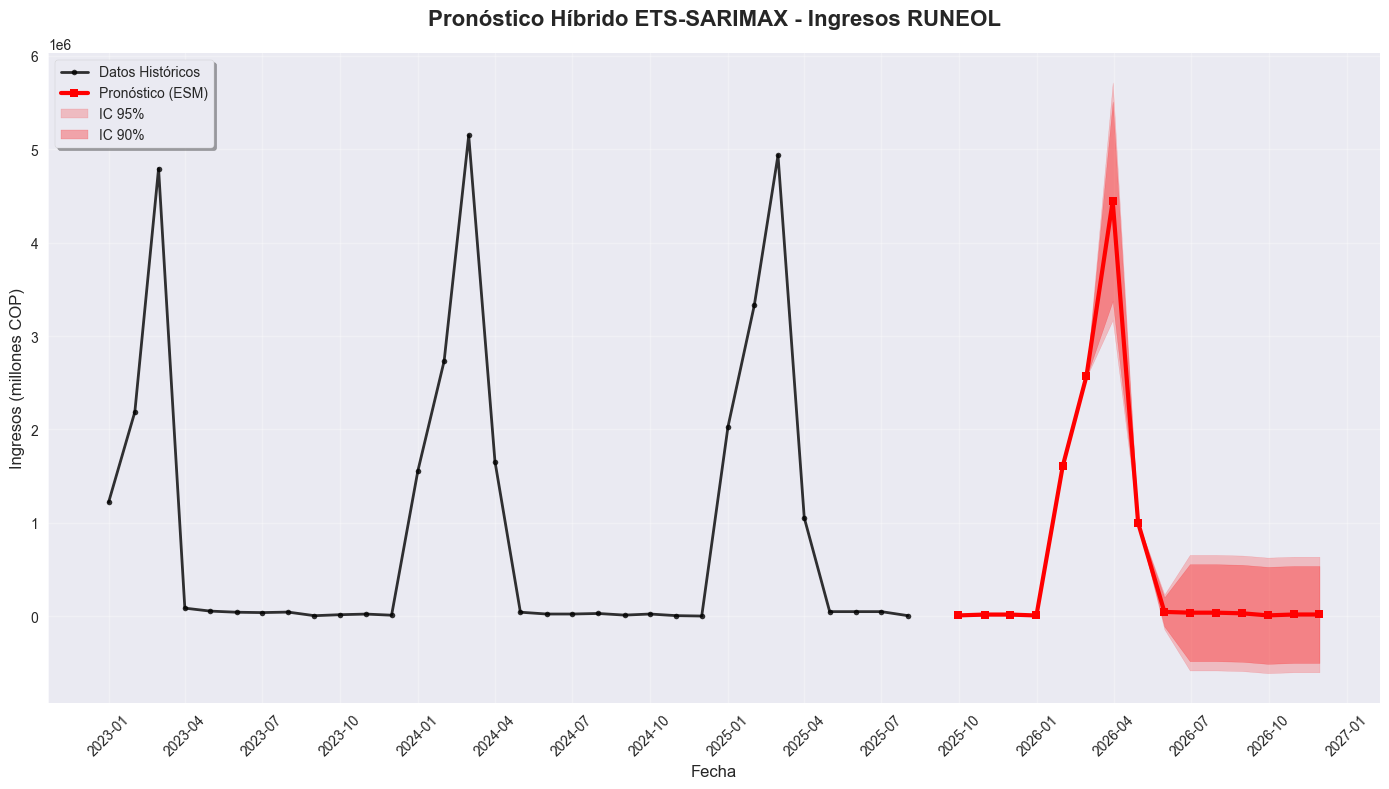

In [28]:
# Verificar columnas disponibles
print("Columnas de reno (datos históricos):")
print(reno.columns.tolist())
print("\nColumnas de pronosticos_final (datos de pronóstico):")
print(pronosticos_final.columns.tolist())

# Visualizar el pronóstico híbrido con intervalos de confianza usando la nueva función
plot_forecast_with_intervals(
    historical_data=reno,
    forecast_data=pronosticos_final,
    main_col='ESM',  # Corregido: usar 'ESM' en lugar de 'mean'
    ds_col='ds', 
    y_col='y',
    title='Pronóstico Híbrido ETS-SARIMAX - Ingresos RUNEOL',
    y_label='Ingresos (millones COP)',
    figsize=(14, 8)
)

## Análisis de Variación Esperada para 2026

In [29]:
# Calcular variación porcentual anual usando la función
# Crear una copia temporal con nombres de columnas consistentes
pronosticos_temp = pronosticos_final.copy()
pronosticos_temp = pronosticos_temp.rename(columns={'Fecha': 'ds'})

results = calculate_annual_variation(
    historical_data=reno,
    forecast_data=pronosticos_temp,
    base_year=2025,
    target_year=2026,
    date_col='ds',
    value_col='y',
    forecast_col='ESM',
    currency='COP',
    show_results=True
)



📊 VARIACIÓN PORCENTUAL ANUAL ESPERADA PARA 2026
Total 2025 (Real):        $11,498,100 millones COP
Total 2026 (Pronóstico):  $9,814,817 millones COP
Variación Absoluta:       $-1,683,283 millones COP
VARIACIÓN PORCENTUAL:     -14.64%


🎯 CONCLUSIÓN: Se espera una DISMINUCIÓN del 14.64% en los ingresos para 2026


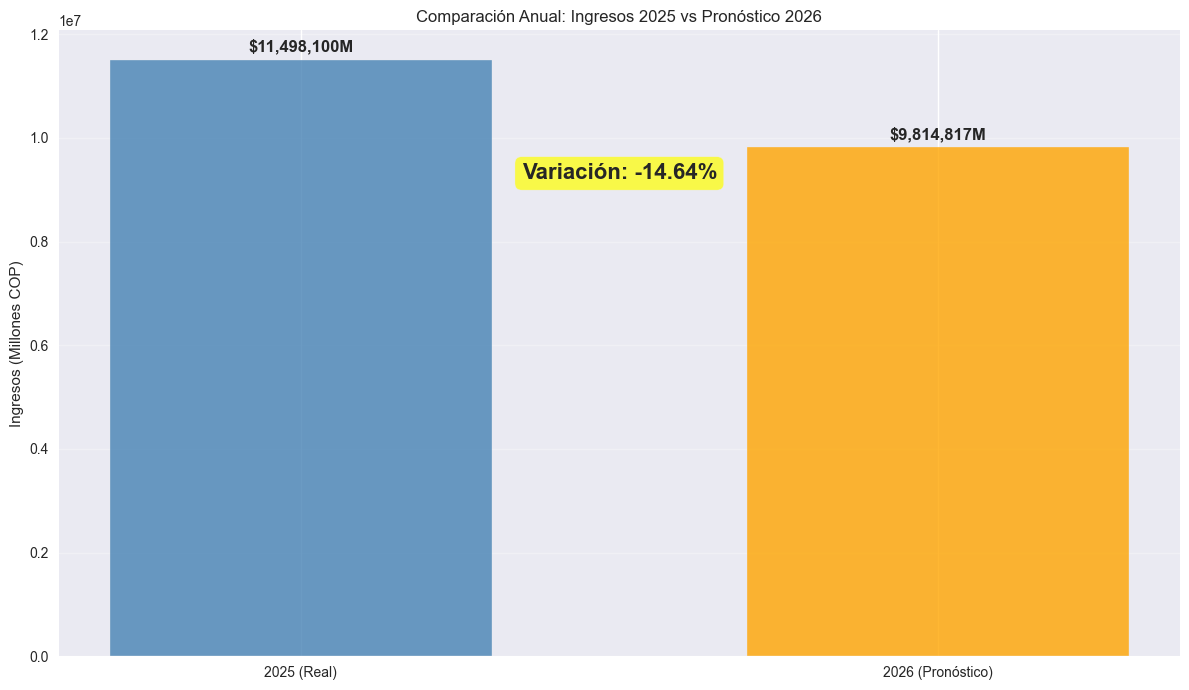

In [30]:
# Crear visualización usando la función
fig, ax = plot_annual_comparison(
    results_dict=results,
    figsize=(12, 7),
    currency='COP'
)

plt.show()

# Exportar datos 

In [31]:
pronosticos_final = pronosticos_final.rename(columns= {"ds": "Fecha"})

In [32]:
file_path = export_data(
    data=pronosticos_final,
    filename="Pronostico Ingresos RUNEOL",
    output_dir="data/model_outputs",
    file_format="csv",
    add_timestamp=False
)

📁 DATOS EXPORTADOS EXITOSAMENTE
Archivo:     Pronostico Ingresos RUNEOL.csv
Directorio:  data/model_outputs
Ruta:        data/model_outputs\Pronostico Ingresos RUNEOL.csv
Formato:     CSV
Tamaño:      0.00 MB
Filas:       15
Columnas:    6
Fecha:       2025-10-15 02:24:52
